[flaml.automl.logger: 11-18 07:10:04] {1728} INFO - task = regression
[flaml.automl.logger: 11-18 07:10:04] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-18 07:10:04] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 11-18 07:10:04] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 11-18 07:10:04] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-18 07:10:04] {2393} INFO - Estimated sufficient time budget=215s. Estimated necessary time budget=2s.
[flaml.automl.logger: 11-18 07:10:04] {2442} INFO -  at 0.0s,	estimator lgbm's best error=0.0200,	best estimator lgbm's best error=0.0200
[flaml.automl.logger: 11-18 07:10:04] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-18 07:10:04] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.0200,	best estimator lgbm's best error=0.0200
[flaml.automl.logger: 11-18 07:10:04] {2258} IN

/opt/anaconda3/envs/mlggeo2024_aobuoypredict/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/mlggeo2024_aobuoypredict/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Iterative Predictions:
Latitude Predictions: [81.60882291666667, 81.60882291666667, 81.60882291666667, 81.60882291666667, 81.60882291666667, 81.60882291666667, 81.60882291666665, 81.60882291666667, 81.60882291666667, 81.60882291666667]
Longitude Predictions: [-150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007, -150.56084000000007]


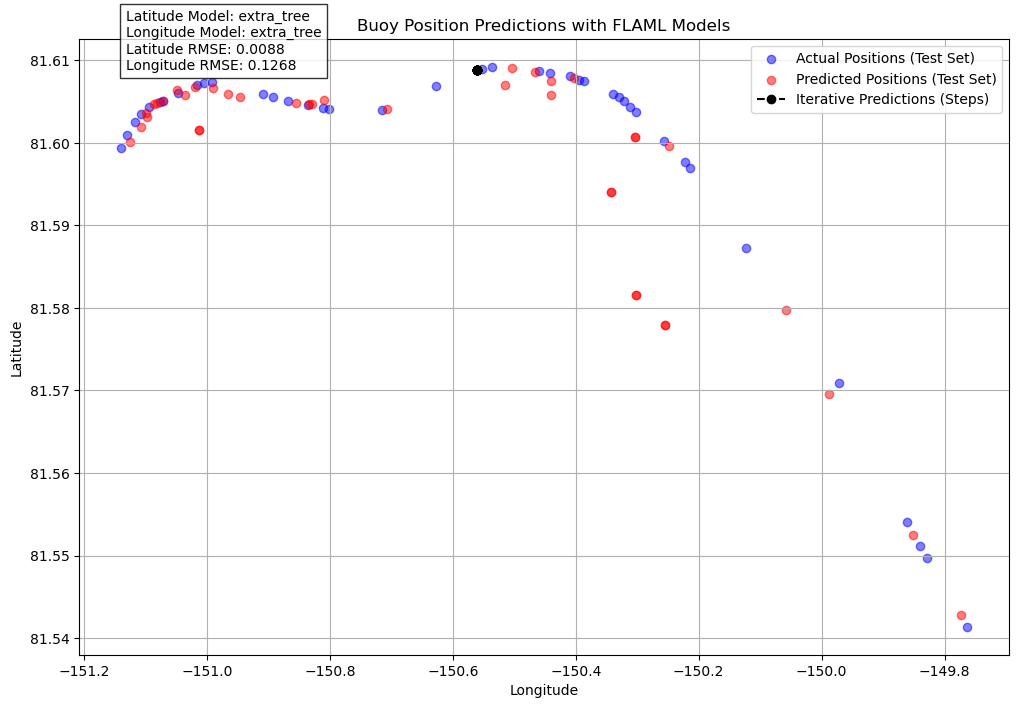

In [15]:
# Import libraries
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = pd.read_csv('combined_buoy_data.csv', nrows=200)

# Define features and targets
X = data[['era5_uwnd', 'era5_vwnd']]  # Features
y_lat = data['Latitude']  # Target for Latitude
y_lon = data['Longitude']  # Target for Longitude

# Split into train and test sets for Latitude
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X, y_lat, test_size=0.2, random_state=42)

# Split into train and test sets for Longitude
X_train_lon, X_test_lon, y_train_lon, y_test_lon = train_test_split(X, y_lon, test_size=0.2, random_state=42)

# Initialize AutoML settings
automl_settings = {
    "time_budget": 120,  # Set time budget in seconds
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": 'flaml_tuning.log'
}

# Train AutoML for Latitude
automl_lat = AutoML()
automl_lat.fit(X_train=X_train_lat, y_train=y_train_lat, **automl_settings)

# Train AutoML for Longitude
automl_lon = AutoML()
automl_lon.fit(X_train=X_train_lon, y_train=y_train_lon, **automl_settings)

# Predictions for Latitude
lat_predictions = automl_lat.predict(X_test_lat)
mae_lat = mean_absolute_error(y_test_lat, lat_predictions)
rmse_lat = mean_squared_error(y_test_lat, lat_predictions, squared=False)

# Predictions for Longitude
lon_predictions = automl_lon.predict(X_test_lon)
mae_lon = mean_absolute_error(y_test_lon, lon_predictions)
rmse_lon = mean_squared_error(y_test_lon, lon_predictions, squared=False)

# Print results for Latitude
print("Latitude Predictions:")
print(f"MAE (Latitude): {mae_lat:.2f}")
print(f"RMSE (Latitude): {rmse_lat:.2f}")

# Print results for Longitude
print("\nLongitude Predictions:")
print(f"MAE (Longitude): {mae_lon:.2f}")
print(f"RMSE (Longitude): {rmse_lon:.2f}")

# Define the iterative prediction function
def iterative_predict(model_lat, model_lon, X_initial, steps=10):
    """
    Uses trained models for Latitude and Longitude to make iterative predictions over multiple steps.

    Parameters:
        model_lat: The trained model for Latitude.
        model_lon: The trained model for Longitude.
        X_initial: The initial input feature set for prediction.
        steps: Number of iterative steps to predict forward.

    Returns:
        A tuple of lists (latitude_predictions, longitude_predictions).
    """
    lat_predictions = []
    lon_predictions = []
    X_current = X_initial.copy()

    for step in range(steps):
        # Predict Latitude and Longitude
        lat_pred = model_lat.predict(X_current)
        lon_pred = model_lon.predict(X_current)

        lat_predictions.append(lat_pred[0])
        lon_predictions.append(lon_pred[0])

        # Update features (placeholder logic, adapt as needed)
        X_current = update_features_with_prediction(X_current, lat_pred, lon_pred)

    return lat_predictions, lon_predictions

# Define the feature update logic
def update_features_with_prediction(X, lat_pred, lon_pred):
    """
    Updates the input features for the next iteration based on the latest Latitude and Longitude predictions.

    Parameters:
        X: The current input feature set.
        lat_pred: Predicted Latitude.
        lon_pred: Predicted Longitude.

    Returns:
        Updated feature set for the next prediction step.
    """
    X = X.copy()
    X['lat_pred'] = lat_pred
    X['lon_pred'] = lon_pred
    return X

# Test iterative prediction
initial_features = X_test_lat.iloc[0:1]  # Use Latitude's test features as the starting point
lat_preds, lon_preds = iterative_predict(automl_lat, automl_lon, initial_features, steps=10)

# Print iterative predictions
print("\nIterative Predictions:")
print("Latitude Predictions:", lat_preds)
print("Longitude Predictions:", lon_preds)

# Add model information and metrics to the plot
def plot_predictions_with_model_info(y_test_lat, y_test_lon, lat_predictions, lon_predictions, lat_iter_preds, lon_iter_preds, automl_lat, automl_lon):
    """
    Plots actual vs predicted positions and iterative predictions with FLAML model info.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot actual positions
    plt.scatter(y_test_lon, y_test_lat, color='blue', label='Actual Positions (Test Set)', alpha=0.5)
    
    # Plot predicted positions (test set predictions)
    plt.scatter(lon_predictions, lat_predictions, color='red', label='Predicted Positions (Test Set)', alpha=0.5)
    
    # Plot iterative predictions
    plt.plot(lon_iter_preds, lat_iter_preds, color='black', label='Iterative Predictions (Steps)', marker='o', linestyle='--')
    
    # Add labels, legend, and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Buoy Position Predictions with FLAML Models')
    plt.legend()
    plt.grid(True)
    
    # Annotate with model info
    plt.text(
        0.05, 0.95, 
        f"Latitude Model: {automl_lat.best_estimator}\n"
        f"Longitude Model: {automl_lon.best_estimator}\n"
        f"Latitude RMSE: {automl_lat.best_loss:.4f}\n"  # Note: best_loss instead of best_loss_
        f"Longitude RMSE: {automl_lon.best_loss:.4f}",
        fontsize=10,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    # Show plot
    plt.show()


# Call the updated plotting function
plot_predictions_with_model_info(
    y_test_lat=y_test_lat,
    y_test_lon=y_test_lon,
    lat_predictions=lat_predictions,
    lon_predictions=lon_predictions,
    lat_iter_preds=lat_preds,
    lon_iter_preds=lon_preds,
    automl_lat=automl_lat,
    automl_lon=automl_lon
)

